# 206 Crunch TCRE and ZEC for FaIR
We use the REN_NZCO2 from the PROVIDE scenarios.

In [1]:
import pyam
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path

<IPython.core.display.Javascript object>

## Read in the necessary data

In [2]:
data_folder = Path("../data")
historical_emission_file = data_folder / "rcmip-emissions-annual-means-v5-1-0.csv"
emission_file = data_folder / "tier1_emissions.csv"
temperature_file = data_folder / "fair_temperatures/scen_Ren_NZCO2.csv"

In [3]:
df_hist_emissions = pyam.IamDataFrame(historical_emission_file)

pyam - INFO: Running in a notebook, setting up a basic logging at level INFO
pyam.core - INFO: Reading file ../data/rcmip-emissions-annual-means-v5-1-0.csv


In [4]:
df_emissions = pyam.IamDataFrame(emission_file)

pyam.core - INFO: Reading file ../data/tier1_emissions.csv


In [5]:
df_temperature = pd.read_csv(temperature_file)

## Data processing
We first filter out the emission dataframe for the necessary scenario "Ren_NZCO2".

In [6]:
df_nzco2 = (
    df_emissions.filter(
        scenario="Ren_NZCO2",
        variable="Emissions|CO2*"
    )
)

In [7]:
df_nzco2.variable

['Emissions|CO2|AFOLU', 'Emissions|CO2|Energy and Industrial Processes']

We need to affix the pre-2015 emissions.

In [8]:
df_hist_emissions.scenario

['esm-bell-1000PgC',
 'esm-bell-2000PgC',
 'esm-bell-750PgC',
 'esm-pi-CO2pulse',
 'esm-pi-cdr-pulse',
 'esm-piControl',
 'historical',
 'historical-cmip5',
 'rcp26',
 'rcp45',
 'rcp60',
 'rcp85',
 'ssp119',
 'ssp126',
 'ssp245',
 'ssp370',
 'ssp370-lowNTCF-aerchemmip',
 'ssp370-lowNTCF-gidden',
 'ssp434',
 'ssp460',
 'ssp534-over',
 'ssp585']

In [9]:
df_hist_pre_2015 = (
    df_hist_emissions
    .filter(
        scenario="ssp245",
        year=range(1750,2015),
        region="World",
        variable=["Emissions|CO2|MAGICC AFOLU","Emissions|CO2|MAGICC Fossil and Industrial"]
    )
)

In [10]:
df_hist_pre_2015.variable

['Emissions|CO2|MAGICC AFOLU', 'Emissions|CO2|MAGICC Fossil and Industrial']

In [11]:
df_hist_pre_2015.rename(
    variable={
        "Emissions|CO2|MAGICC AFOLU":"Emissions|CO2|AFOLU",
        "Emissions|CO2|MAGICC Fossil and Industrial":"Emissions|CO2|Energy and Industrial Processes"
    },
    inplace=True
)

In [12]:
df_hist_pre_2015_pyam = pyam.IamDataFrame(
    df_hist_pre_2015
    .filter(variable=df_nzco2.variable)
    .rename(
        model={df_hist_pre_2015.model[0]:df_nzco2.model[0]},
        scenario={df_hist_pre_2015.scenario[0]:df_nzco2.scenario[0]}
    )
    .timeseries()
    .reset_index()
    .drop(columns=["mip_era", "activity_id"])
)

In [13]:
df_compiled = pyam.concat(
    [df_nzco2, df_hist_pre_2015_pyam]
)

/Users/gauravganti/opt/anaconda3/envs/provide_perspective/lib/python3.10/site-packages/pyam/plotting.py:1073: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, data in df.iteritems():


<Axes: title={'center': 'model: REMIND-MAgPIE 2.1-4.3 - scenario: Ren_NZCO2 - region: World'}, xlabel='Year', ylabel='Mt CO2/yr'>

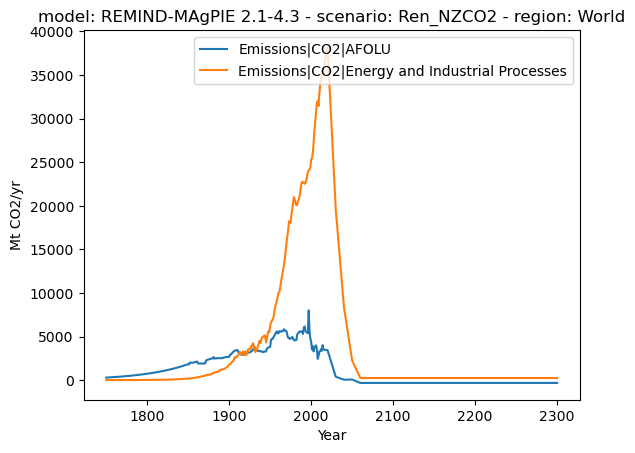

In [14]:
df_compiled.plot()

Now, we want to create an aggregate "Emissions|CO2" variable.

In [15]:
df_co2 = df_compiled.aggregate(
    variable="Emissions|CO2",
    components=[
        "Emissions|CO2|AFOLU",
        "Emissions|CO2|Energy and Industrial Processes"
    ]
)

Now, we want to interpolate for the 10 year time steps. And then filter out for the necessary years.

In [16]:
df_co2.interpolate(
    time=range(2015,2301),
    inplace=True
)

/Users/gauravganti/opt/anaconda3/envs/provide_perspective/lib/python3.10/site-packages/pyam/core.py:662: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col] = newdf[col]
/Users/gauravganti/opt/anaconda3/envs/provide_perspective/lib/python3.10/site-packages/pyam/core.py:662: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col] = newdf[col]
/Users/gauravganti/opt/anaconda3/envs/provide_perspective/lib/python3.10/site-packages/pyam/core.py:662: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of ca

In [17]:
df_co2.filter(
    year=range(1850,2301),
    inplace=True
)

Now, we should format the temperature data.

In [18]:
df_temp_proc = df_temperature.set_index('year').T.reset_index()

In [19]:
df_temp_proc['variable'] = df_temp_proc['index'].apply(
    lambda x: f'Surface Temperature|run_id_{x}'
)

In [20]:
df_temp_proc_pyam = pyam.IamDataFrame(
    df_temp_proc.assign(
        model=df_co2.model[0],
        scenario=df_co2.scenario[0],
        region='World',
        unit='K'
    )
    .drop(columns='index')
)

Add this in to the CO2 emissions dataframe.

In [21]:
df_tcre = pyam.concat(
    [
        df_temp_proc_pyam,
        df_co2
    ]
)

In [22]:
df_tcre_2000_2100 = df_tcre.filter(year=range(2000,2101))

In [23]:
df_tcre_2000_2100.convert_unit(
    current='Mt CO2/yr',
    to='Eg C/yr',
    inplace=True
)

First, we need to find the year of net zero CO2 emissions.

In [24]:
year_of_nzco2 = df_co2.timeseries()[df_co2.timeseries()<=0.1].dropna(axis=1).columns.min()

In [25]:
year_of_nzco2

2060

/Users/gauravganti/opt/anaconda3/envs/provide_perspective/lib/python3.10/site-packages/pyam/plotting.py:1073: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, data in df.iteritems():
pyam.plotting - INFO: >=13 labels, not applying legend


<Axes: title={'center': 'model: REMIND-MAgPIE 2.1-4.3 - scenario: Ren_NZCO2 - region: World'}, xlabel='Year', ylabel='K'>

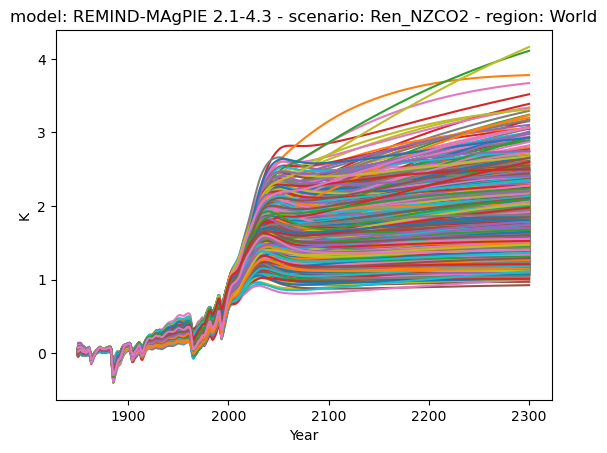

In [26]:
df_temp_proc_pyam.plot()

We first want to calculate the cumulative emissions until net zero CO2 is reached.

In [27]:
df_tcre_2000_2100.set_meta(
    meta=(
        df_co2
        .convert_unit(
            current='Mt CO2/yr',
            to='Eg C/yr'
        )
        .timeseries()
        .apply(
            lambda x: 
                pyam.cumulative(
                    x,
                    first_year=2000,
                    last_year=year_of_nzco2
                ),
            axis=1
        )
    ),
    name=f'cum_emi_2000_{year_of_nzco2}'
)

Now, we want to add the cumulative emissions between 2060 and 2100.

This will be useful for the tcre_down calculations.

In [28]:
df_tcre_2000_2100.set_meta(
    meta=(
        df_co2
        .convert_unit(
            current='Mt CO2/yr',
            to='Eg C/yr'
        )
        .timeseries()
        .apply(
            lambda x: 
                pyam.cumulative(
                    x,
                    first_year=year_of_nzco2,
                    last_year=2100
                ),
            axis=1
        )
    ),
    name=f'cum_emi_{year_of_nzco2}_2100'
)

In [29]:
df_tcre_2000_2100.meta

exclude  cum_emi_2000_2060  cum_emi_2060_2100
model                 scenario                                                
REMIND-MAgPIE 2.1-4.3 Ren_NZCO2    False           0.341076          -0.000707

Hmm, we may run into issues with this. It is probably a good idea to estimate this independently.

Now we want to assign the deltaT over the same time period to get the TCRE of each ensemble member.

In [30]:
temps = df_tcre_2000_2100.filter(variable='Surface Temperature*').timeseries()

In [31]:
temps.loc[:,f'deltaT_{year_of_nzco2}_2000'] = temps.loc[:,year_of_nzco2] - temps.loc[:,2000]

In [32]:
temps.loc[:,f'deltaT_2100_{year_of_nzco2}'] = temps.loc[:,2100] - temps.loc[:,year_of_nzco2]

Now, we assign a columns with the cumulative emissions

In [33]:
temps.loc[:,f'cum_emi_2000_{year_of_nzco2}']=df_tcre_2000_2100.meta['cum_emi_2000_2060']

In [34]:
temps_for_tcre = temps.loc[:,[2060, 'deltaT_2060_2000','deltaT_2100_2060','cum_emi_2000_2060']]

In [35]:
temps_for_tcre.loc[:,'tcre'] = temps_for_tcre.loc[:,'deltaT_2060_2000'] / temps_for_tcre.loc[:,'cum_emi_2000_2060']

<Axes: ylabel='Frequency'>

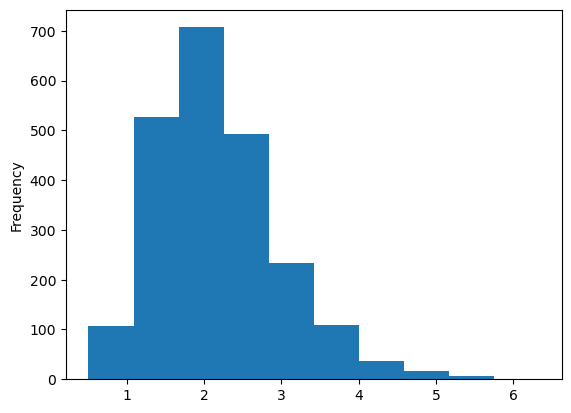

In [36]:
temps_for_tcre['tcre'].plot(kind='hist')

In [37]:
temps_for_tcre = temps_for_tcre.reset_index()

In [38]:
temps_for_tcre.loc[:, 'climate_model'] = ''

Lets scatter TCRE and ZEC.

<Axes: xlabel='deltaT_2100_2060', ylabel='tcre'>

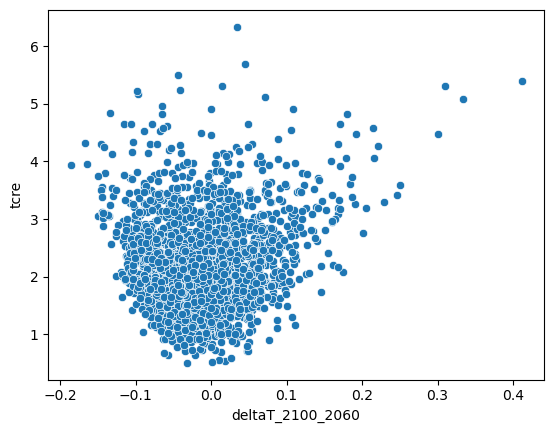

In [39]:
sns.scatterplot(
    data=temps_for_tcre,
    y='tcre',
    x='deltaT_2100_2060'
)

Save this out for further analysis.

In [40]:
temps_for_tcre.to_excel('processed_data/206_proc_fair_ren_nzco2.xlsx')

In [41]:
df_tcre_2000_2100.filter(year=range(2000,2101)).to_excel('processed_data/206_ren_nzco2_emi.xlsx')